# Election Modeling and Prediction Pipeline

This notebook implements an advanced election modeling pipeline that includes:
- Poll data generation and preprocessing
- Feature engineering and model training
- Uncertainty quantification
- Prediction visualization

In [1]:
# Setup and Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# Plotting settings
sns.set_theme()  # Use this instead of plt.style.use('seaborn')
sns.set_palette("husl")

In [2]:
# Configuration and Parameters
NUM_STATES = 32  # Number of states in Mexico
NUM_POLLS = 100  # Number of polls to generate
CANDIDATES = ["Candidate A", "Candidate B"]

TRAIN_SIZE = 0.8
N_BOOTSTRAP = 1000  # Number of bootstrap iterations for uncertainty estimation

In [3]:
# Data Generation and Preprocessing
def generate_enhanced_polling_data(num_states, num_polls, candidates):
    states = [f"State_{i+1}" for i in range(num_states)]

    state_characteristics = pd.DataFrame({
        'State': states,
        'Historical_Turnout': np.random.normal(65, 10, num_states),
        'Urban_Population_Pct': np.random.normal(70, 15, num_states),
        'Median_Income': np.random.normal(50000, 15000, num_states)
    })

    data = []
    for _ in range(num_polls):
        poll_id = f"Poll_{np.random.randint(1000, 9999)}"
        state = np.random.choice(states)
        sample_size = np.random.randint(500, 2000)
        date = pd.Timestamp.now() - pd.Timedelta(days=np.random.randint(0, 30))
        state_data = state_characteristics[state_characteristics['State'] == state].iloc[0]
        base_support = np.random.dirichlet(np.ones(len(candidates))) * 100
        urban_effect = (state_data['Urban_Population_Pct'] - 70) / 100
        income_effect = (state_data['Median_Income'] - 50000) / 50000
        support = base_support + np.array([urban_effect, -urban_effect]) + np.array([income_effect, -income_effect])
        support = np.clip(support, 0, 100)
        undecided = max(0, 100 - sum(support))
        methodology_score = np.random.normal(7.5, 1.5)
        poll_data = {
            "Poll_ID": poll_id,
            "State": state,
            "Sample_Size": sample_size,
            "Date": date,
            "Methodology_Score": methodology_score,
            "Historical_Turnout": state_data['Historical_Turnout'],
            "Urban_Population_Pct": state_data['Urban_Population_Pct'],
            "Median_Income": state_data['Median_Income'],
            **{f"{cand}_Support": s for cand, s in zip(candidates, support)},
            "Undecided": undecided
        }
        data.append(poll_data)
    return pd.DataFrame(data)

In [4]:
# Data Processing and Feature Engineering
def process_polling_data(df):
    now = pd.Timestamp.now()
    df['Days_Until_Election'] = (df['Date'] - now).dt.days
    df['Sample_Size_Score'] = (df['Sample_Size'] - df['Sample_Size'].min()) / \
                             (df['Sample_Size'].max() - df['Sample_Size'].min())
    df['Recency_Weight'] = 1 / (1 + np.abs(df['Days_Until_Election']))
    df['Quality_Weight'] = (df['Methodology_Score'] * df['Sample_Size_Score'])
    df['Total_Weight'] = df['Recency_Weight'] * df['Quality_Weight']
    return df

def prepare_modeling_features(df):
    features = [
        'Sample_Size_Score', 'Methodology_Score',
        'Historical_Turnout', 'Urban_Population_Pct',
        'Median_Income', 'Days_Until_Election'
    ]
    state_dummies = pd.get_dummies(df['State'], prefix='State')
    X = pd.concat([df[features], state_dummies], axis=1)
    y = df[[f"{cand}_Support" for cand in CANDIDATES]]
    return X, y

In [5]:
# Model Definition
class ElectionModel:
    def __init__(self):
        self.models = {}
        self.scalers = {}

    def train(self, X, y):
        for candidate in CANDIDATES:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scalers[candidate] = scaler
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                random_state=42
            )
            model.fit(X_scaled, y[f"{candidate}_Support"])
            self.models[candidate] = model

    def predict(self, X):
        predictions = {}
        uncertainties = {}
        for candidate in CANDIDATES:
            X_scaled = self.scalers[candidate].transform(X)
            bootstrap_preds = []
            for _ in range(N_BOOTSTRAP):
                indices = np.random.choice(len(X), size=len(X), replace=True)
                X_boot = X_scaled[indices]
                pred = self.models[candidate].predict(X_boot)
                bootstrap_preds.append(pred)
            predictions[candidate] = np.mean(bootstrap_preds, axis=0)
            uncertainties[candidate] = np.std(bootstrap_preds, axis=0)
        return predictions, uncertainties

In [6]:
# Visualization Functions
def plot_predictions(predictions, uncertainties, y_test):
    plt.figure(figsize=(12, 6))
    for i, candidate in enumerate(CANDIDATES):
        true_values = y_test[f"{candidate}_Support"]
        pred_values = predictions[candidate]
        uncertainty = uncertainties[candidate]
        plt.subplot(1, 2, i+1)
        plt.errorbar(true_values, pred_values,
                    yerr=uncertainty,
                    fmt='o',
                    alpha=0.5,
                    label=f'{candidate} Predictions')
        plt.plot([0, 100], [0, 100], '--', color='gray', alpha=0.5)
        plt.xlabel('Actual Support (%)')
        plt.ylabel('Predicted Support (%)')
        plt.title(f'{candidate} Support Predictions')
        plt.legend()
    plt.tight_layout()
    plt.show()

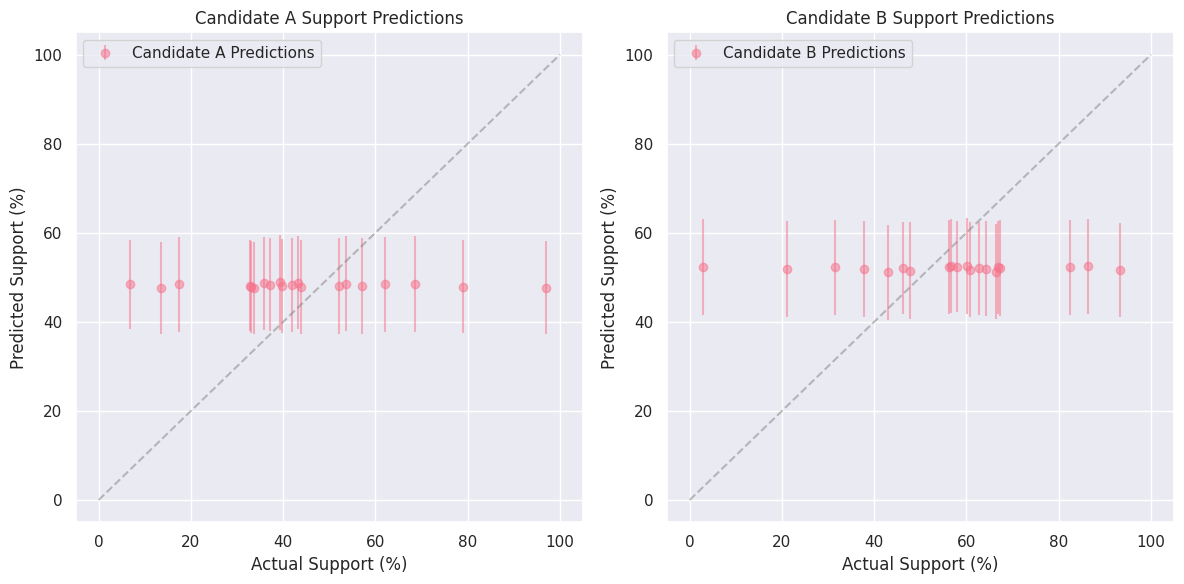

In [7]:
# Main Execution
if __name__ == "__main__":
    polling_data = generate_enhanced_polling_data(NUM_STATES, NUM_POLLS, CANDIDATES)
    processed_data = process_polling_data(polling_data)
    X, y = prepare_modeling_features(processed_data)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=42
    )
    model = ElectionModel()
    model.train(X_train, y_train)
    predictions, uncertainties = model.predict(X_test)
    plot_predictions(predictions, uncertainties, y_test)